In [219]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [220]:
lr = 0.0001
batch_size = 32
n_epochs = 1000

embedding_dim = 3
lstm_hidden_size = 10
lstm_num_layers = 2

In [221]:
df = pd.read_csv(
    "../data/TweetsSentiment/preprocessed_tweets_labeled.csv",
    sep=";",
    header=0,
    index_col=0,
)

df.head()

,text,label
id,,
77522,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",0
661634,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,2
413231,Net issuance increases to fund fiscal programs...,0
760262,RT @bentboolean: How much of Amazon's traffic ...,0
830153,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,0


In [222]:
from sklearn.model_selection import train_test_split

dataset = df.to_numpy()

X = dataset[:, 0]
Y = dataset[:, 1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, random_state=42)

In [223]:
text_iter = iter(X_train)

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(text_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [224]:
def add_padding(arr, max_len):

  zeros = np.zeros(0)
  if len(arr) < max_len:
    zeros = np.zeros(max_len - len(arr))
  arr = np.concatenate((zeros, arr))

  return arr

In [225]:
max_len = np.max([len(x) for x in X])
print(max_len)

text_pipeline = np.vectorize(lambda x: add_padding(vocab(tokenizer(x)), max_len))

344


In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device {device} is being used')

Device cuda is being used


In [227]:
train_inputs = torch.from_numpy(np.array(list(map(text_pipeline, X_train)))).type(torch.LongTensor).to(device)
train_targets = torch.from_numpy(Y_train.astype(np.longlong)).type(torch.LongTensor).to(device)
test_inputs = torch.from_numpy(np.array(list(map(text_pipeline, X_test)))).type(torch.LongTensor).to(device)
test_targets = torch.from_numpy(Y_test.astype(np.longlong)).type(torch.LongTensor).to(device)

print(train_inputs.shape)
print(train_targets.shape)
print(test_inputs.shape)
print(test_targets.shape)

torch.Size([975, 344])
torch.Size([975])
torch.Size([325, 344])
torch.Size([325])


In [228]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_inputs, train_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

In [229]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        output_size,
        hidden_size,
        num_layers,
    ):
        super(RNN, self).__init__()
        
        self.V = vocab_size
        self.D = embedding_dim
        self.K = output_size
        self.M = hidden_size
        self.L = num_layers
        
        self.emb = nn.Embedding(
            num_embeddings=self.V,
            embedding_dim=self.D,
        )
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers = self.L,
            batch_first=True,
        )
        self.fc = nn.Linear(
            in_features=self.M,
            out_features=self.K,
        )
    
    def forward(self, inputs):
        h0 = torch.zeros((self.L, inputs.size(0), self.M)).to(device)
        c0 = torch.zeros((self.L, inputs.size(0), self.M)).to(device)
        
        outputs = self.emb(inputs)
        outputs, _ = self.rnn(outputs, (h0, c0))
        outputs = self.fc(outputs[:, -1, :])
        
        return outputs

In [230]:
model = RNN(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    output_size=3,
    hidden_size=lstm_hidden_size,
    num_layers=lstm_num_layers,
)

model.to(device)

RNN(
  (emb): Embedding(6991, 3)
  (rnn): LSTM(3, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)

In [231]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [232]:
def validate(dataset, batch_size=128):
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
    )

    tot_predicted = 0
    tot_correct = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        tot_predicted += inputs.shape[0]
        outputs = model(inputs)

        _, predictions = torch.max(outputs, dim=1)

        tot_correct += (predictions == targets).sum()

    return (tot_correct/tot_predicted)

In [233]:
def train(n_epochs=100):

    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    train_accuracies = np.zeros(n_epochs)
    test_accuracies = np.zeros(n_epochs)

    for it in range(n_epochs):

        train_loss = []
        test_loss = []

        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        train_losses[it] = np.mean(train_loss)

        for i, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        test_losses[it] = np.mean(test_loss)

        train_accuracies[it] = validate(train_dataset, batch_size=batch_size)
        test_accuracies[it] = validate(test_dataset, batch_size=batch_size)

        print(
            f"Iteration: {it+1:4.0f}/{n_epochs}\tTrain Loss: {train_losses[it]:.6f}\tTest Loss: {test_losses[it]:.6f}\tTrain Accuracy: {train_accuracies[it]:.6f}\tTest Accuracy: {test_accuracies[it]:.6f}"
        )

    return train_losses, test_losses, train_accuracies, test_accuracies


In [234]:
train_losses, test_losses, train_accuracies, test_accuracies = train(n_epochs=n_epochs)


Iteration:    1/1000	Train Loss: 1.119316	Test Loss: 1.116419	Train Accuracy: 0.259487	Test Accuracy: 0.292308
Iteration:    2/1000	Train Loss: 1.115917	Test Loss: 1.114588	Train Accuracy: 0.259487	Test Accuracy: 0.292308
Iteration:    3/1000	Train Loss: 1.112423	Test Loss: 1.112923	Train Accuracy: 0.259487	Test Accuracy: 0.292308
Iteration:    4/1000	Train Loss: 1.109042	Test Loss: 1.111420	Train Accuracy: 0.259487	Test Accuracy: 0.292308
Iteration:    5/1000	Train Loss: 1.107352	Test Loss: 1.110089	Train Accuracy: 0.259487	Test Accuracy: 0.292308
Iteration:    6/1000	Train Loss: 1.104828	Test Loss: 1.108944	Train Accuracy: 0.263590	Test Accuracy: 0.292308
Iteration:    7/1000	Train Loss: 1.102332	Test Loss: 1.107775	Train Accuracy: 0.333333	Test Accuracy: 0.326154
Iteration:    8/1000	Train Loss: 1.099743	Test Loss: 1.106700	Train Accuracy: 0.398974	Test Accuracy: 0.366154
Iteration:    9/1000	Train Loss: 1.097341	Test Loss: 1.105842	Train Accuracy: 0.414359	Test Accuracy: 0.369231
I

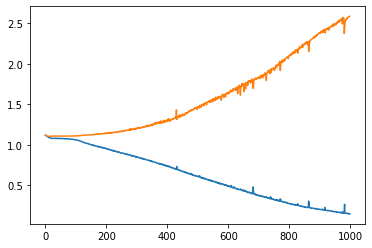

In [235]:
plt.plot(train_losses)
plt.plot(test_losses)

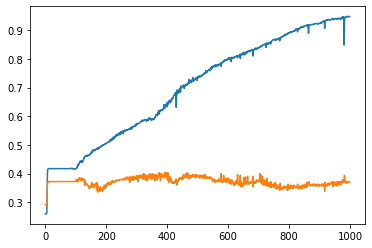

In [236]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)